In [50]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch


import math
import os
import shutil

import time

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

from utils import img_preprocessing, get_foot,distance,create_or_delete_folder

## dicom_path and out_path

In [51]:
OutPut_dir = 'OutPut'
for i in [OutPut_dir]:
    create_or_delete_folder(i)


dcom_dir = 'dicom_input'
dcom_path = r'dicom_input\test001.dcm'


Folder 'OutPut' has been deleted and recreated.


## Load the models

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


detector = init_detector(
    'weightsAndconfig/rtmdet_tiny_triangle.py',
    'weightsAndconfig/best_coco_bbox_mAP_epoch_235.pth',
    device=device
)


pose_estimator = init_pose_estimator(
    'weightsAndconfig/rtmpose-s-triangle.py',
    'weightsAndconfig/best_PCK_epoch_420.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)


init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

pose_estimator.cfg.visualizer.radius = 10
pose_estimator.cfg.visualizer.line_width = 5
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

Loads checkpoint by local backend from path: weightsAndconfig/best_coco_bbox_mAP_epoch_235.pth
Loads checkpoint by local backend from path: weightsAndconfig/best_PCK_epoch_420.pth


c:\Users\lijie\.conda\envs\MMD\lib\site-packages\mmengine\utils\manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


## Preprocessing

In [53]:
start_time = time.time()
test_clahe_RGB, scaled_image,Pixel_Spacing = img_preprocessing(dcom_path)
image_with_point = test_clahe_RGB.copy()
image_with_line = test_clahe_RGB.copy()

## Inference

In [54]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))
detect_result = inference_detector(detector, test_clahe_RGB)

CONF_THRES = 0.5

pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

pose_results = inference_topdown(pose_estimator, test_clahe_RGB, bboxes)
data_samples = merge_data_samples(pose_results)
keypoints = data_samples.pred_instances.keypoints.astype('int')


img_output = visualizer.add_datasample(
        'result',
        test_clahe_RGB,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        show_kpt_idx=True,
        wait_time=0,
        kpt_thr=0.1
)

height = img_output.shape[0]
width = img_output.shape[1]
pred_image = img_output[:height//2, :]
headmap_image = img_output[height//2:, :]

h:\mmdetection\mmpose\mmpose\models\heads\coord_cls_heads\rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


## Measurements

In [55]:
dic_landmak = {}
dic_landmak['P1'] = keypoints[0,1,:].tolist()
dic_landmak['P2'] = keypoints[0,2,:].tolist()
dic_landmak['A1'] = keypoints[0,0,:].tolist()
dic_landmak['N2'] = keypoints[0,3,:].tolist()
dic_landmak['N1'] = keypoints[0,4,:].tolist()

list_line = dic_landmak['P1'] + dic_landmak['P2']
list_point = dic_landmak['A1']

A2 = get_foot(list_point,list_line)  
dic_landmak['A2'] = A2
A_distance = round(distance(dic_landmak['A2'][0], dic_landmak['A2'][1], dic_landmak['A1'][0], dic_landmak['A1'][1],float(Pixel_Spacing)),3)
N_distance = round(distance(dic_landmak['N2'][0], dic_landmak['N2'][1], dic_landmak['N1'][0], dic_landmak['N1'][1],float(Pixel_Spacing)),3)
AN_ratio = round(A_distance/N_distance,3) 


end_time = time.time() 
elapsed_time = end_time - start_time

## Results visualization

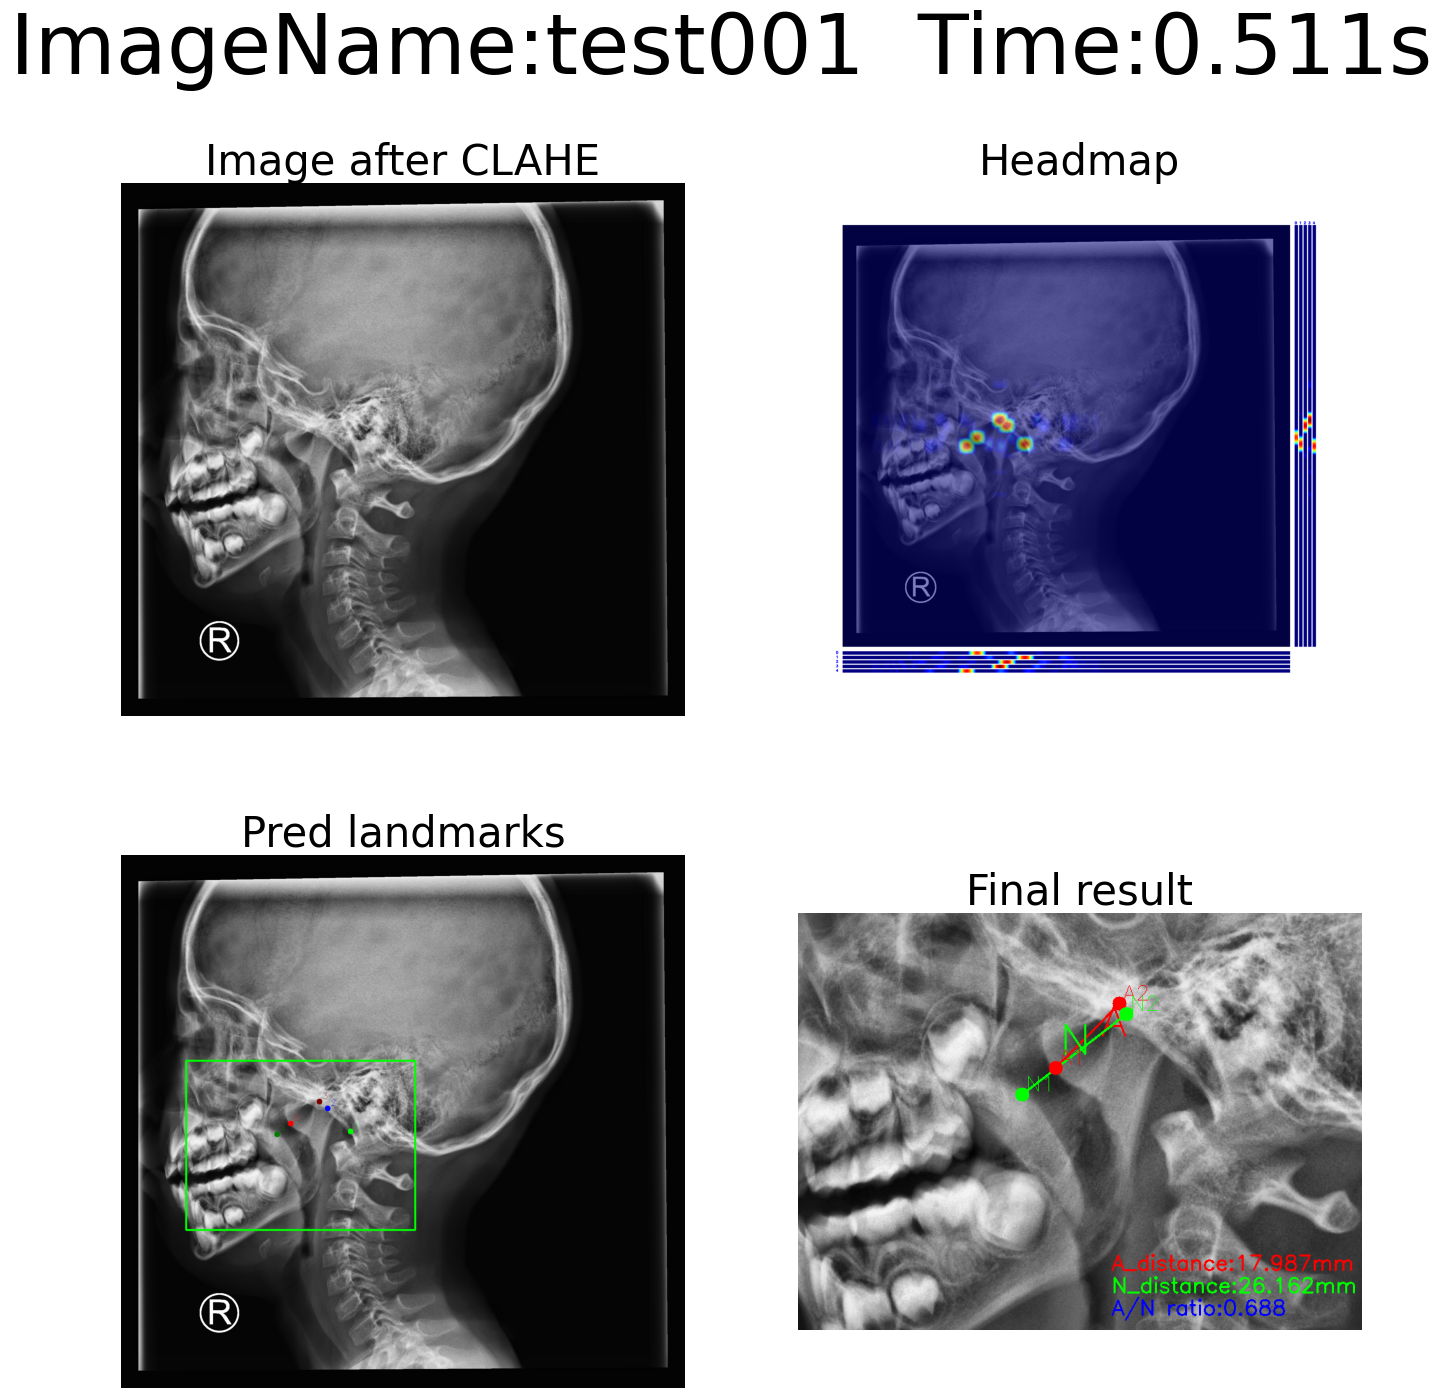

In [56]:
lines_info = [
    (dic_landmak['A1'], dic_landmak['A2'], (255, 0, 0), "A"),  # 第一条线段
    (dic_landmak['N1'], dic_landmak['N2'], (0, 255, 0), "N")   # 第二条线段
    ]
    
points_info_1 = [
    (dic_landmak['A1'], (255, 0, 0), "A1"),
    (dic_landmak['A2'], (255, 0, 0), "A2"),
    (dic_landmak['N1'], (0, 255, 0), "N1"),
    (dic_landmak['N2'], (0, 255, 0), "N2"),    
    ]

font_line = cv2.FONT_HERSHEY_SIMPLEX
font_scale_line = 2
font_thickness_line = 2

font_point = cv2.FONT_HERSHEY_SIMPLEX
font_scale_point = 1
font_thickness_point = 1


text1 = f"A_distance:{A_distance:.3f}mm"    
text2 = f"N_distance:{N_distance:.3f}mm" 
text3 = f"A/N ratio:{AN_ratio:.3f}" 


pianyi = 20
for (start_point, end_point, color, line_name) in lines_info:
    # 绘制线段
    cv2.line(image_with_line, start_point, end_point, color, thickness=2)
    
    # 文本位置（通常位于线段中点附近）
    text_position = ((start_point[0] + end_point[0]) // 2 + pianyi, 
                    (start_point[1] + end_point[1]) // 2)
    
    # 添加文本
    cv2.putText(image_with_line, line_name, text_position, font_line, font_scale_line, color, font_thickness_line)

    pianyi = -20

for point, color, name in points_info_1:
    cv2.circle(image_with_line, point, radius=10, color=color, thickness=-1)
    cv2.putText(image_with_line, name, (point[0]+5, point[1]-5), font_point, font_scale_point, color, font_thickness_point)




x1, y1 = bboxes[0][0], bboxes[0][1]   # 起始点坐标
x2, y2 = bboxes[0][2], bboxes[0][3] # 结束点坐标

cropped_image = image_with_line[y1:y2, x1:x2]

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 2
font_color = (255, 255, 255)  # 白色

# 计算文本的宽度和高度
(text_width, text_height), baseline = cv2.getTextSize(text1, font, font_scale, font_thickness)

# 图像尺寸
img_height, img_width = cropped_image.shape[:2]

# 文本位置
text1_position = (img_width - text_width - 10, img_height - 3 * text_height - 20)
text2_position = (img_width - text_width - 10, img_height - 2 * text_height - 10)
text3_position = (img_width - text_width - 10, img_height - text_height)


cv2.putText(cropped_image, text1, text1_position, font, font_scale, (255, 0, 0), font_thickness)
cv2.putText(cropped_image, text2, text2_position, font, font_scale, (0, 255, 0), font_thickness)
cv2.putText(cropped_image, text3, text3_position, font, font_scale, (0, 0, 255), font_thickness)


plt.figure(figsize=(16, 16))

plt.subplot(2,2,1),plt.imshow(test_clahe_RGB, 'gray')
plt.axis('off'),plt.title('Image after CLAHE',fontsize=30)

plt.subplot(2,2,2),plt.imshow(headmap_image)
plt.axis('off'),plt.title('Headmap',fontsize=30)

plt.subplot(2,2,3),plt.imshow(pred_image)
plt.axis('off'),plt.title('Pred landmarks',fontsize=30)

plt.subplot(2,2,4),plt.imshow(cropped_image)
plt.axis('off'),plt.title('Final result',fontsize=30)

Name_png = dcom_path.split('.')[0].split('\\')[1]

plt.suptitle(f"ImageName:{Name_png}  Time:{round(elapsed_time,3)}s",fontsize=60,x=0.5,y=0.98)
save_path = os.path.join(OutPut_dir,dcom_path.split('\\')[1].replace('.dcm','.png'))
plt.savefig(save_path,dpi=300)
plt.show()

